In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

## Test for Problems

In [3]:
class ConvLayer1(keras.layers.Layer):
    def __init__(self):
        super(ConvLayer1, self).__init__()
        self.conv1 = keras.layers.Conv2D(32, 3, activation="relu", padding="same")
        self.conv2 = keras.layers.Conv2D(16, 3, activation="relu", padding="same")
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(inputs)
        return x
    
class ConvLayer2(keras.layers.Layer):
    def __init__(self):
        super(ConvLayer2, self).__init__()
    
    def call(self, inputs, training=None):
        x = keras.layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
        x = keras.layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
        return x

In [4]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
model1 = ConvLayer1()
model2 = ConvLayer2()
outputs1 = model1(inputs)
outputs2 = model2(inputs)
keras.Model(inputs, outputs1).summary()
keras.Model(inputs, outputs2).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_layer1 (ConvLayer1)     (None, 32, 32, 16)        1344      
Total params: 1,344
Trainable params: 1,344
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_layer2 (ConvLayer2)     (None, 32, 32, 16)        0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


## Customize Layer for Model

In [3]:
class ConvForRB(keras.layers.Layer):
    def __init__(self, num_features, kernel_size=3, stride=1):
        super(ConvForRB, self).__init__()
        self.bn = keras.layers.BatchNormalization(
            scale=True,
            center=True,
            trainable=True
        )
        self.conv = keras.layers.Conv2D(
            num_features,
            kernel_size,
            strides=stride,
            padding='same',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
            kernel_regularizer=keras.regularizers.L2(1e-4),
            bias_initializer=keras.initializers.Zeros()
        )
    
    # I think BatchNormalization should take place after activation to avoid reducing the effect of update step,
    # which means just working for inputs from next layer,
    # according to paper BatchNormalization
    def call(self, inputs):
        x = self.bn(inputs)
        x = keras.activations.relu(x)
        x = self.conv(x)
        return x

class SkipForRB(keras.layers.Layer):
    def __init__(self, num_in, num_out):
        super(SkipForRB, self).__init__()
        self.num_in = num_in
        self.num_out = num_out
        self.conv = keras.layers.Conv2D(
            num_out,
            1,
            strides=1,
            padding='same',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
            kernel_regularizer=keras.regularizers.L2(1e-4),
            bias_initializer=keras.initializers.Zeros()
        )
    
    def call(self, inputs):
        if self.num_in == self.num_out:
            x = tf.identity(inputs)
        else:
            x = self.conv(inputs)
        return x
    
class ResidualBlock(keras.layers.Layer):
    def __init__(self, num_in, num_out):
        super(ResidualBlock, self).__init__()
        half_num_out = max(int(num_out/2), 1)
        self.conv1 = ConvForRB(num_features=half_num_out, kernel_size=1, stride=1)
        self.conv2 = ConvForRB(num_features=half_num_out, kernel_size=3, stride=1)
        self.conv3 = ConvForRB(num_features=num_out, kernel_size=1, stride=1)
        self.skip = SkipForRB(num_in, num_out)
        
    def call(self, inputs):
        c = self.conv1(inputs)
        c = self.conv2(c)
        c = self.conv3(c)
        s = self.skip(inputs)
        x = c + s
        return x

## Define method for Model

In [3]:
#@tf.function
def build_rb(x, num_in, num_out):
    half_num_out = max(int(num_out/2), 1)
    
    # Lower branch
    c = x    
    # Conv1
    c = keras.layers.BatchNormalization(scale=True, center=True, trainable=True)(c)
    c = keras.activations.relu(c)
    c = keras.layers.Conv2D(
        filters=half_num_out, 
        kernel_size=1, 
        strides=1, 
        padding='same',
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
        kernel_regularizer=keras.regularizers.L2(1e-4),
        bias_initializer=keras.initializers.Zeros()
       )(c)
    
    # Conv2
    c = keras.layers.BatchNormalization(scale=True, center=True, trainable=True)(c)
    c = keras.activations.relu(c)
    c = keras.layers.Conv2D(
        filters=half_num_out, 
        kernel_size=3, 
        strides=1, 
        padding='same',
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
        kernel_regularizer=keras.regularizers.L2(1e-4),
        bias_initializer=keras.initializers.Zeros()
       )(c)
    
    # Conv3
    c = keras.layers.BatchNormalization(scale=True, center=True, trainable=True)(c)
    c = keras.activations.relu(c)
    c = keras.layers.Conv2D(
        filters=num_out, 
        kernel_size=1, 
        strides=1, 
        padding='same',
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
        kernel_regularizer=keras.regularizers.L2(1e-4),
        bias_initializer=keras.initializers.Zeros()
       )(c)
    
    # Upper branch
    s = x
    # Skip
    if num_in == num_out:
        s = tf.identity(s)
    else:
        s = keras.layers.Conv2D(
            filters=num_out, 
            kernel_size=1, 
            strides=1, 
            padding='same',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
            kernel_regularizer=keras.regularizers.L2(1e-4),
            bias_initializer=keras.initializers.Zeros()
           )(s)
    x = c + s
    return x

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 32, 32, 3)    12          input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Relu_6 (TensorFlowO [(None, 32, 32, 3)]  0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 1)    4           tf_op_layer_Relu_6[0][0]         
____________________________________________________________________________________________

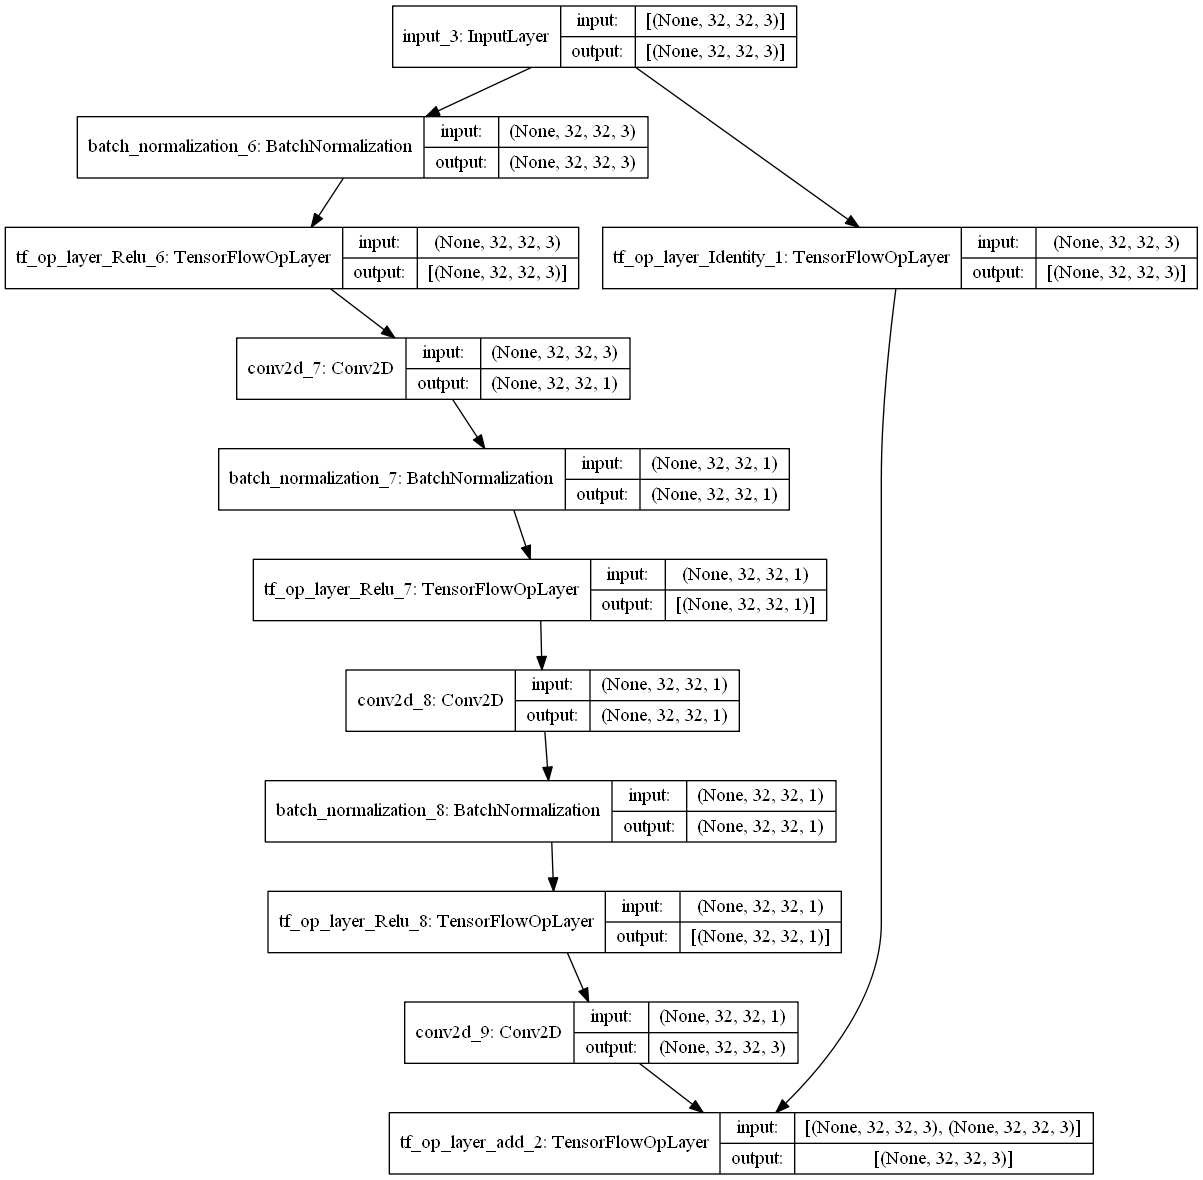

In [7]:
inputs = keras.Input(shape=(32, 32, 3))
x = build_rb(inputs, 3, 3)

model = keras.Model(inputs, x)
model.summary()
keras.utils.plot_model(model, "rb_test.png", show_shapes=True)

In [8]:
#@tf.function
def build_hg(x, steps_to_go, num_features, num_rb=1):
    # Upper branch
    up1 = x
    for i in range(num_rb):
        up1 = build_rb(up1, num_features, num_features)
    
    # Lower branch
    low1 = keras.layers.MaxPool2D(pool_size=2)(x)
    for i in range(num_rb):
        low1 = build_rb(low1, num_features, num_features)
        
    # Recursive
    if steps_to_go > 1:
        low2 = build_hg(low1, steps_to_go=steps_to_go-1, num_features=num_features)
    else:
        low2 = low1
        for i in range(num_rb):
            low2 = build_rb(low2, num_features, num_features)
            
    # Additional rb
    low3 = low2
    for i in range(num_rb):
        low3 = build_rb(low3, num_features, num_features)
        
    # Upsampling
    up2 = keras.layers.UpSampling2D(size=2, interpolation='bilinear')(low3)
    
    x = up1 + up2
    return x

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 16, 16, 3)    12          max_pooling2d[0][0]              
__________________________________________________________________________________________________
tf_op_layer_Relu_12 (TensorFlow [(None, 16, 16, 3)]  0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

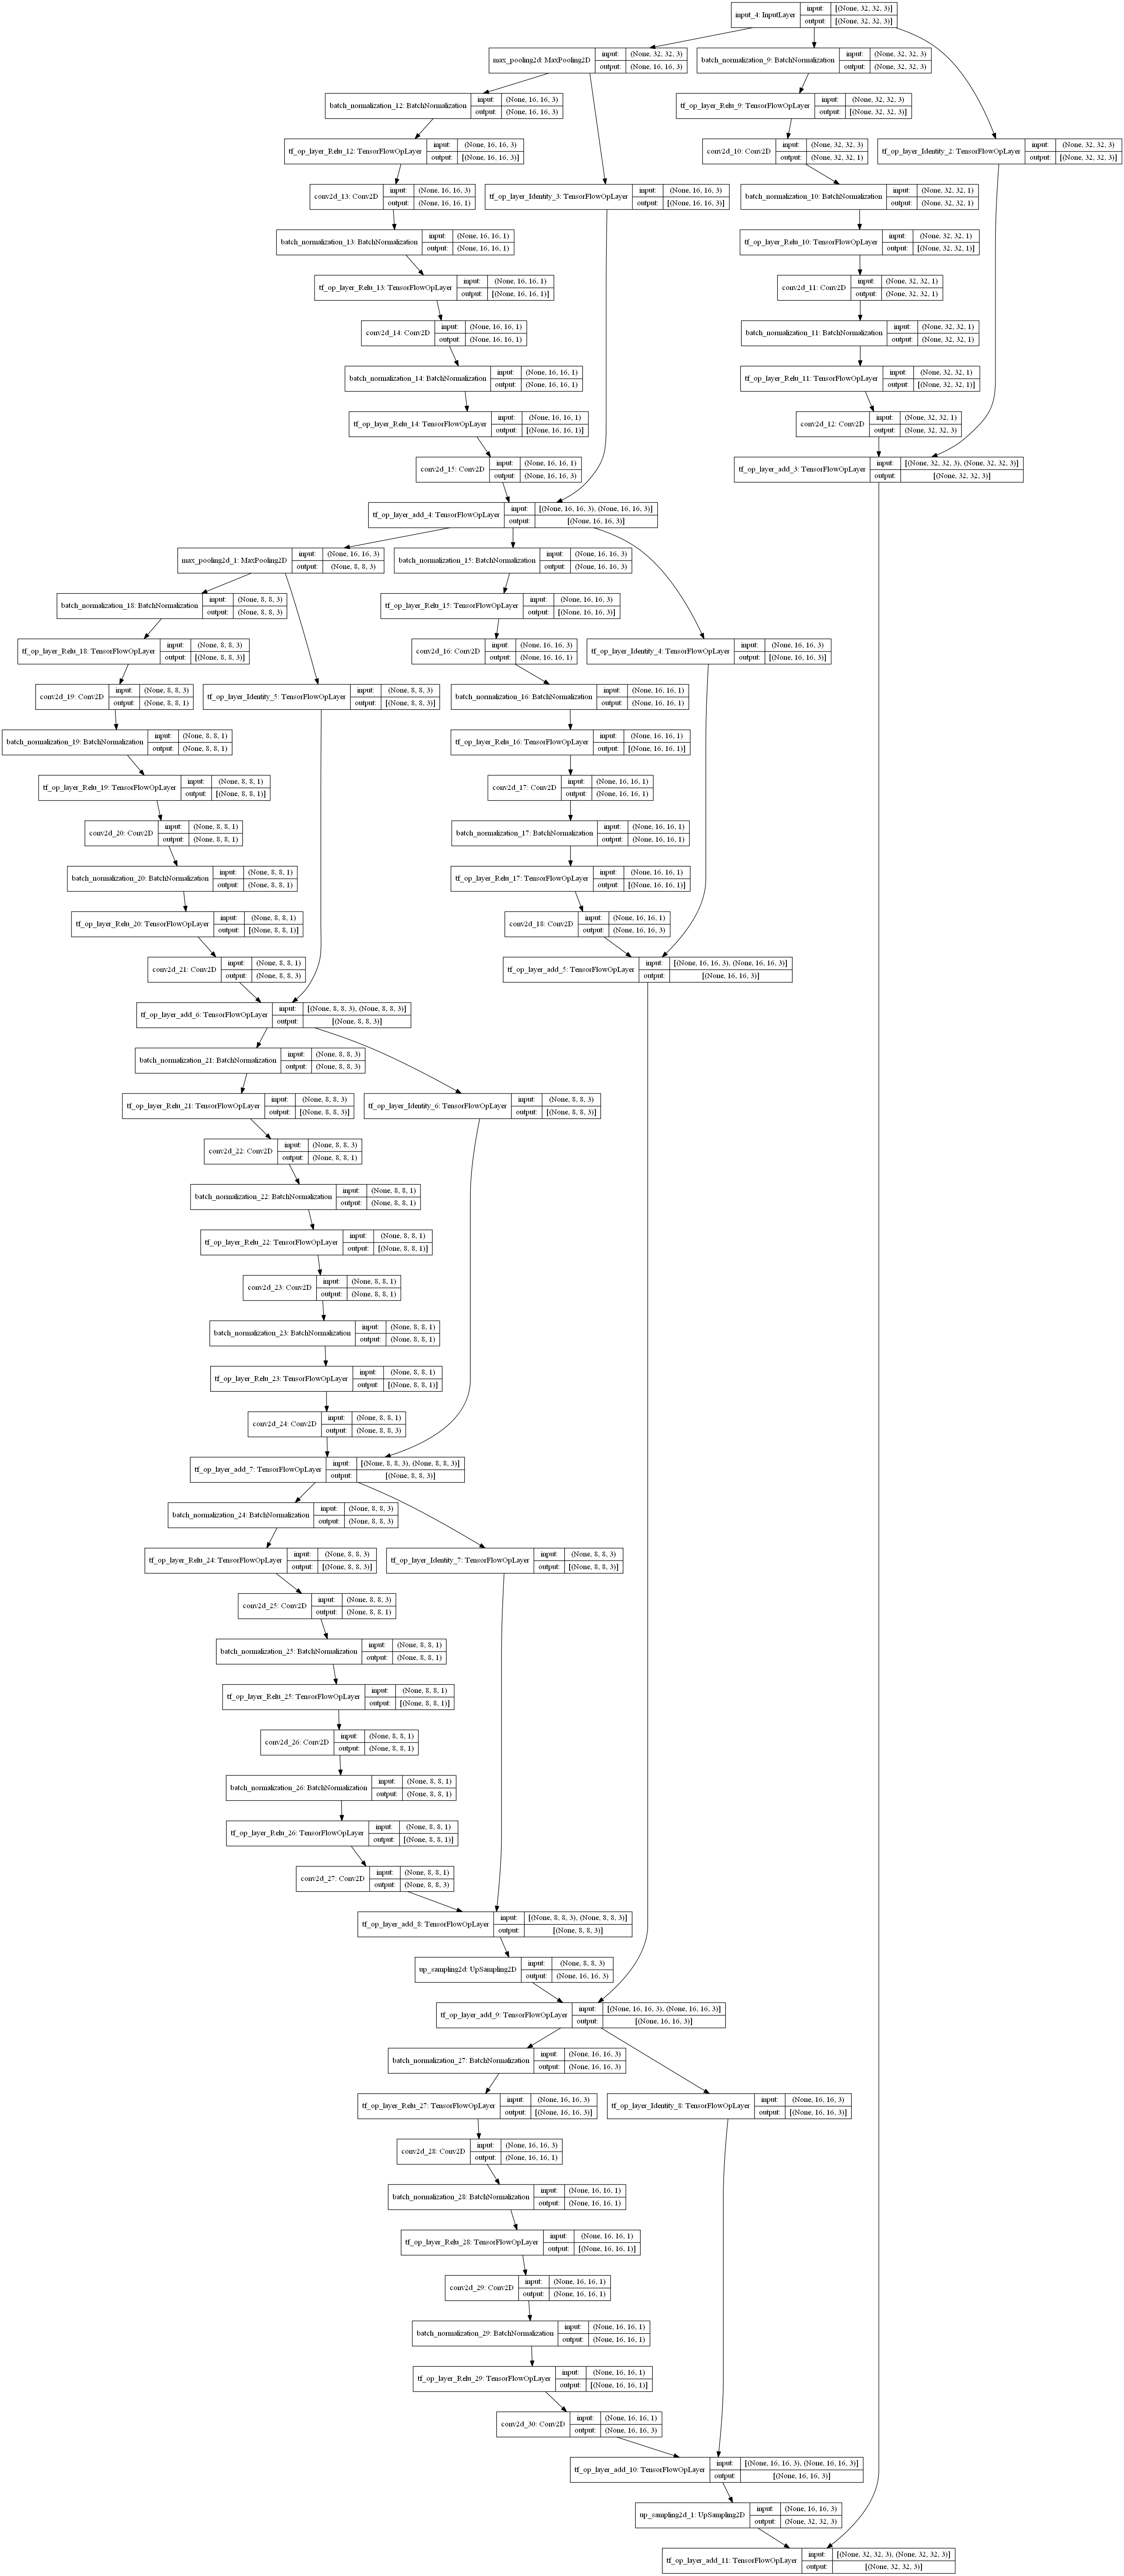

In [9]:
inputs = keras.Input(shape=(32, 32, 3))
x = build_hg(inputs, 2, 3)

model = keras.Model(inputs, x)
model.summary()
keras.utils.plot_model(model, "hg_test.png", show_shapes=True)

In [17]:
def build_hg_after(x_prev, x_now, num_feature_maps, num_landmarks, num_rb, do_merge=True):
    # After
    for i in range(num_rb):
        x_now = build_rb(x_now, num_feature_maps, num_feature_maps)
        
    x_now = keras.layers.Conv2D(
        filters=num_feature_maps, 
        kernel_size=1, 
        strides=1, 
        padding='same',
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
        kernel_regularizer=keras.regularizers.L2(1e-4),
        bias_initializer=keras.initializers.Zeros()
        )(x_now)
    x_now = keras.layers.BatchNormalization(scale=True, center=True, trainable=True)(x_now)
    x_now = keras.activations.relu(x_now)
    
    # Heatmap
    h = keras.layers.Conv2D(
        filters=num_landmarks, 
        kernel_size=1, 
        strides=1, 
        padding='same',
        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
        kernel_regularizer=keras.regularizers.L2(1e-4),
        bias_initializer=keras.initializers.Zeros()
        )(x_now)
    
    x_next = x_now
    # Merge
    if do_merge:
        # h
        x_hmaps = keras.layers.Conv2D(
            filters=num_feature_maps, 
            kernel_size=1, 
            strides=1, 
            padding='same',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
            kernel_regularizer=keras.regularizers.L2(1e-4),
            bias_initializer=keras.initializers.Zeros()
            )(h)
        # x
        x_now = keras.layers.Conv2D(
            filters=num_feature_maps, 
            kernel_size=1, 
            strides=1, 
            padding='same',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01),
            kernel_regularizer=keras.regularizers.L2(1e-4),
            bias_initializer=keras.initializers.Zeros()
            )(x_now)
        x_next += x_prev + x_hmaps
    return x_next, h

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 16, 16, 3)    0           input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 16, 16, 3)    12          max_pooling2d_16[0][0]           
__________________________________________________________________________________________________
tf_op_layer_Relu_203 (TensorFlo [(None, 16, 16, 3)]  0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

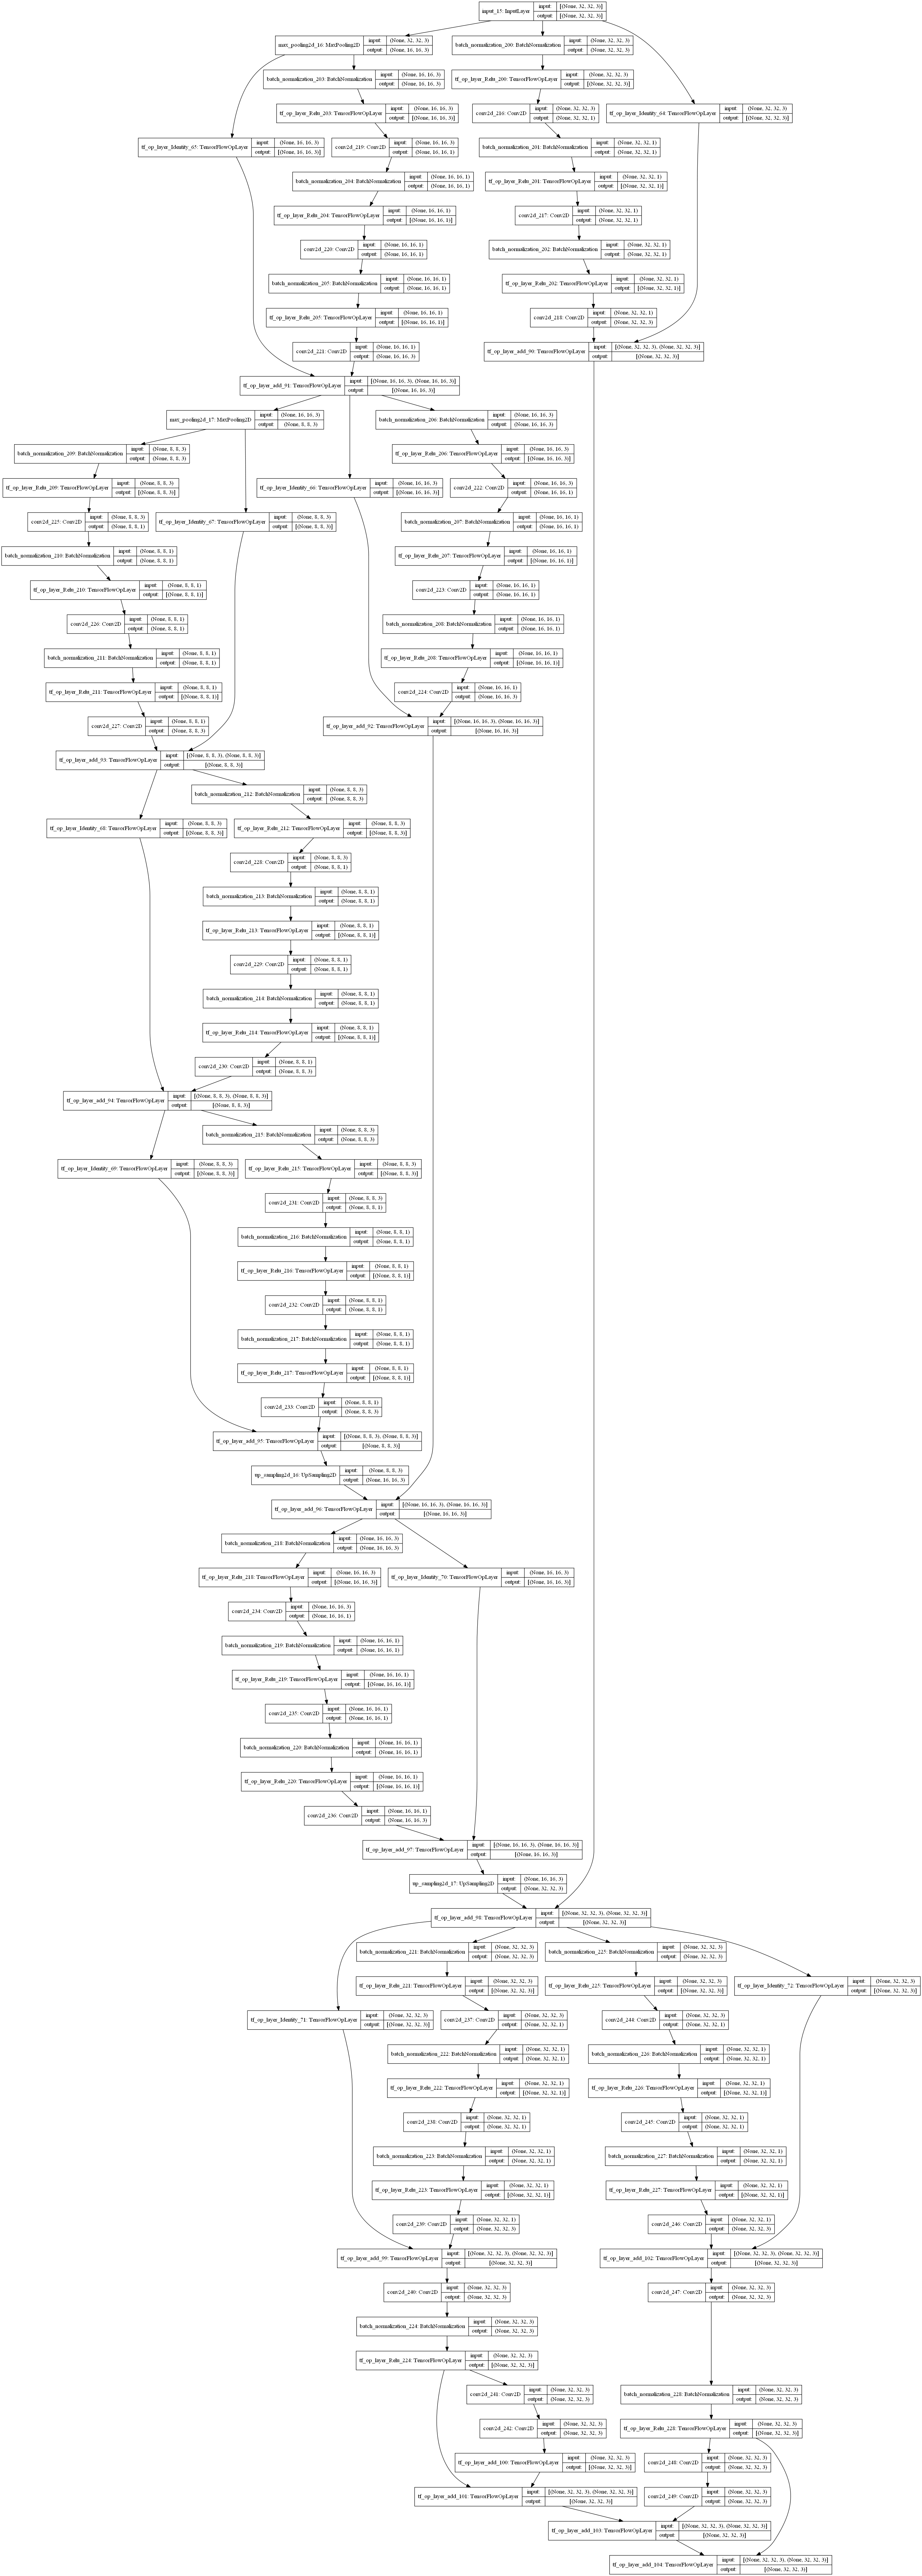

In [19]:
inputs = keras.Input(shape=(32, 32, 3))
inputs_prev = keras.Input(shape=(32, 32, 3))
x = build_hg(inputs, 2, 3)
x1, h1 = build_hg_after(tf.zeros(shape=(32, 32, 3)), x, 3, 3, 1)
x2, h2 = build_hg_after(x1, x, 3, 3, 1)

model = keras.Model(inputs, x2)
model.summary()
keras.utils.plot_model(model, "hg_after_test.png", show_shapes=True)